<a href="https://colab.research.google.com/github/namitasathish/IndiVision/blob/main/IndiVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load Dataset

In [ ]:
import pandas as pd
import os
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub


dataset = pd.read_csv('/content/indian_food.csv')
print(dataset.head())

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

             name                                        ingredients  \
0          Boondi                            Gram flour, ghee, sugar   
1  Gajar ka halwa       Carrots, milk, sugar, ghee, cashews, raisins   
2          Ghevar  Flour, ghee, kewra, milk, clarified butter, su...   
3     Gulab jamun  Milk powder, plain flour, baking powder, ghee,...   
4          Imarti                          Sugar syrup, lentil flour   

         diet  prep_time  cook_time flavor_profile   course        state  \
0  vegetarian         80         30          sweet  dessert    Rajasthan   
1  vegetarian         15         60          sweet  dessert       Punjab   
2  vegetarian         15         30          sweet  dessert    Rajasthan   
3  vegetarian         15         40          sweet  dessert  West Bengal   
4  vegetarian         10         50          sweet  dessert  West Bengal   

  region  
0   West  
1  North  
2   West  
3   East  
4   East  
Drive already mounted at /content/drive; to 

Counting Image Folders and Images

In [66]:
image_folder = '/content/drive/My Drive/food_images'


dish_folders = os.listdir(image_folder)


total_files = 0
total_folders = 0

for dish_folder in dish_folders:
    folder_path = os.path.join(image_folder, dish_folder)
    if os.path.isdir(folder_path):
        total_folders += 1
        files = os.listdir(folder_path)
        file_count = len(files)
        total_files += file_count


print(f"\nTotal folders: {total_folders}")
print(f"Total files across all folders: {total_files}")



Total folders: 264
Total files across all folders: 1329


Loading and Preprocessing Images and Labels

In [ ]:
labels = []
images = []

for dish in dataset['name']:
    dish_folder = os.path.join(image_folder, dish)
    if os.path.isdir(dish_folder):
        for image_file in os.listdir(dish_folder):
            image_path = os.path.join(dish_folder, image_file)
            try:
                image = Image.open(image_path)
                image = image.resize((224, 224))
                images.append(np.array(image))
                labels.append(dish)
            except Exception as e:
                print(f"Error processing image {image_path}: {e}")

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)


print("Shape of images array:", images.shape)
print("Shape of labels array:", labels.shape)


Shape of images array: (1010, 224, 224, 3)
Shape of labels array: (1010,)


Encode Labels and Train test split

In [ ]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)


x_train, x_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=2)

# Normalize images and ensure correct data types
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = y_train.astype('int')
y_test = y_test.astype('int')


print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)


Shape of x_train: (808, 224, 224, 3)
Shape of y_train: (808,)
Shape of x_test: (202, 224, 224, 3)
Shape of y_test: (202,)


Define and Compile the Model

In [ ]:
mobilenet_model = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
pretrained_model = hub.KerasLayer(mobilenet_model, input_shape=(224, 224, 3), trainable=False)

num_classes = len(np.unique(encoded_labels))
model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_12 (KerasLayer  (None, 1280)              2257984   
 )                                                               
                                                                 
 dense_12 (Dense)            (None, 203)               260043    
                                                                 
Total params: 2518027 (9.61 MB)
Trainable params: 260043 (1015.79 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


 Train and Evaluate the Model

In [ ]:
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {accuracy*100:.2f}%")


Epoch 1/10
26/26 [==============================] - 44s 2s/step - loss: 5.6476 - accuracy: 0.0223 - val_loss: 5.0477 - val_accuracy: 0.0545
Epoch 2/10
26/26 [==============================] - 33s 1s/step - loss: 2.9369 - accuracy: 0.5136 - val_loss: 3.9972 - val_accuracy: 0.2228
Epoch 3/10
26/26 [==============================] - 38s 1s/step - loss: 1.5028 - accuracy: 0.8874 - val_loss: 3.4813 - val_accuracy: 0.2970
Epoch 4/10
26/26 [==============================] - 38s 1s/step - loss: 0.7852 - accuracy: 0.9740 - val_loss: 3.2479 - val_accuracy: 0.3218
Epoch 5/10
26/26 [==============================] - 38s 1s/step - loss: 0.4535 - accuracy: 0.9926 - val_loss: 3.1525 - val_accuracy: 0.3218
Epoch 6/10
26/26 [==============================] - 39s 2s/step - loss: 0.2906 - accuracy: 0.9988 - val_loss: 3.1270 - val_accuracy: 0.3317
Epoch 7/10
26/26 [==============================] - 37s 1s/step - loss: 0.2016 - accuracy: 1.0000 - val_loss: 3.0726 - val_accuracy: 0.3465
Epoch 8/10
26/26 [==

User Interaction for Predicting Dish Name

Enter the path to the image: /content/drive/MyDrive/Testing Images/pongal.jpeg
1/1 [==============================] - 0s 47ms/step


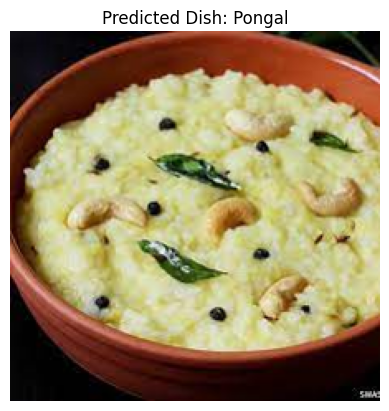

In [67]:
import matplotlib.pyplot as plt

def predict_dish(image_path):
    try:

        image = Image.open(image_path)
        image = image.resize((224, 224))
        processed_image = np.array(image) / 255.0
        processed_image = np.expand_dims(processed_image, axis=0)


        predictions = model.predict(processed_image)
        predicted_class = np.argmax(predictions, axis=1)
        predicted_label = label_encoder.inverse_transform(predicted_class)[0]

        return predicted_label, image
    except Exception as e:
        return f"Error processing image {image_path}: {e}", None

# Ask user for the image path and display the prediction
user_image_path = input("Enter the path to the image: ")
predicted_dish, image = predict_dish(user_image_path)

if image is not None:

    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Predicted Dish: {predicted_dish}')
    plt.show()
else:
    print(predicted_dish)

